In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Perspectief 4: Inkomensongelijkheid

Grote verschillen tussen top en basis versterken statusangst, wantrouwen en het gevoel er niet bij te horen.  
Die psychosociale stressoren werken als stille sluipers:  
ze verhogen chronische ontevredenheid en dragen bij aan depressieve gevoelens los van absolute armoede.

### Gebruikte datasets

- **CPDS (Comparative Political Data Set)**  
  Bron: University of Bern  
  Relevante variabelen: de Gini-coëfficiënt per land/jaar (een maat voor inkomensongelijkheid).

- **Burden of Disease – Depressive Disorders (DALY)**  
  Bron: OurWorldInData  
  Relevante variabelen: Depressieve stoornissen, gemeten in DALYs per 100.000 inwoners (age-standardized, both sexes)

- **Happiness (Cantril Ladder Score)**  
  Bron: OurWorldInData  
  Relevante variabelen: Zelfgerapporteerd geluk (score van 0–10) per land/jaar.

## Preprocessing-stappen

1. Relevante kolommen geselecteerd uit elk bestand  
   - `gini` (inkomensongelijkheid)  
   - `depression_rate` (depressieve stoornissen als % van de bevolking)  
   - `ladder_score` (zelfgerapporteerd geluk)
2. Datasets samengevoegd op basis van land en jaar (`country`, `year`)
3. ontbrekende waarden verwijderd
4. Per land het gemiddelde genomen van alle beschikbare jaren. Dit zorgt voor 1 datapunt per land met gemiddelde Gini, depressie en geluk
5. Gini-coëfficiënt opgedeeld in 3 groepen (laag / midden / hoog) op basis van kwantielen (gebruikt om groepsverschillen in depressie en geluk visueel weer te geven)


In [ ]:
# Dataset inladen
gini_df = pd.read_excel("db/cpds-1960-2022-update-2024-2.xlsx", sheet_name="DATA")[['country', 'year', 'postfisc_gini']]
gini_df.columns = ['country', 'year', 'gini']

happiness_df = pd.read_csv("db/happiness-cantril-ladder.csv")[['Entity', 'Year', 'Cantril ladder score']]
happiness_df.columns = ['country', 'year', 'ladder_score']

burden_df = pd.read_csv("db/2- burden-disease-from-each-mental-illness(1).csv")[[
    'Entity', 'Year',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders'
]]
burden_df.columns = ['country', 'year', 'depression_daly']

# Merge datasets
df = gini_df.merge(happiness_df, on=['country', 'year'])
df = df.merge(burden_df, on=['country', 'year'])
df = df.dropna()

# Gemiddelde per land
mean_df = df.groupby('country', as_index=False).mean(numeric_only=True)

# Categoriseer ongelijkheid
quantiles = mean_df['gini'].quantile([0.33, 0.66])
mean_df['gini_group'] = pd.cut(
    mean_df['gini'],
    bins=[-float('inf'), quantiles[0.33], quantiles[0.66], float('inf')],
    labels=['Low inequality', 'Medium', 'High inequality']
)


mean_df.head()


,country,year,gini,ladder_score,depression_daly,gini_group
0,Australia,2016.00,31.5000,7.265333,813.999533,High inequality
1,Austria,2015.25,27.8625,7.200025,520.676389,Low inequality
2,Belgium,2015.25,25.8750,6.943812,624.431468,Low inequality
3,Canada,2015.25,31.2875,7.370138,545.253928,High inequality
4,Denmark,2017.00,28.0000,7.569720,596.333348,Low inequality


### Argument 1: Ongelijkheid vergroot status, stress en sociale vergelijking.

In ongelijke samenlevingen vergelijken mensen zich vaker met rijkere groepen.  
Dit leidt tot gevoelens van tekortschieten, falen en sociale uitsluiting.  
De ‘status anxiety’-theorie (Wilkinson & Pickett) stelt dat zulke samenlevingen meer mentale druk ervaren.

*Onderbouwing:*  
- Gini-coëfficiënt ↔ depressie: r = +0.20
- Landen met hoge ongelijkheid rapporteren gemiddeld meer depressie
  (_laag: 3.40%, hoog: 3.62%_)

### Argument 2: Gedeelde middelen nemen af, waardoor sociale samenhang verzwakt

Als inkomensverschillen toenemen, vermindert het vertrouwen in de samenleving.  
Mensen investeren minder in publieke goederen, wat leidt tot vervreemding en eenzaamheid.

*Onderbouwing:*  
- Gini ↔ geluk (Cantril ladder): r = –0.18
- Landen met hoge ongelijkheid zijn gemiddeld minder gelukkig (_laag: 6.99, hoog: 6.51_)

/Users/jankawak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


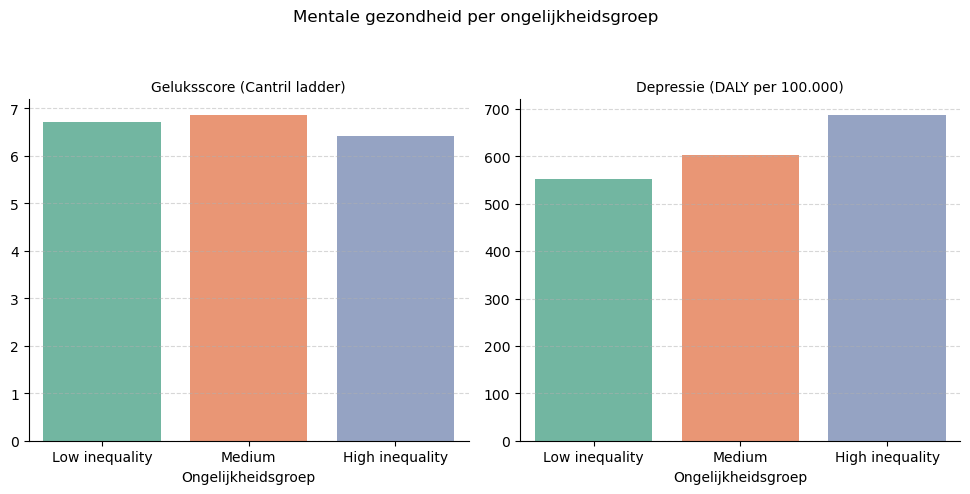

In [27]:
# Gemiddeldes per groep
group_means = mean_df.groupby('gini_group')[['ladder_score', 'depression_daly']].mean().reset_index()

# Omzetten naar lange vorm
melted = group_means.melt(id_vars='gini_group', var_name='Indicator', value_name='Gemiddelde waarde')

# Labels aanpassen voor duidelijkheid
indicator_labels = {
    'ladder_score': 'Geluksscore (Cantril ladder)',
    'depression_daly': 'Depressie (DALY per 100.000)'
}
melted['Indicator'] = melted['Indicator'].replace(indicator_labels)

# Facet barplots
g = sns.catplot(
    data=melted,
    kind='bar',
    x='gini_group',
    y='Gemiddelde waarde',
    col='Indicator',
    palette='Set2',
    sharey=False
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Mentale gezondheid per ongelijkheidsgroep')
g.set_titles('{col_name}')
g.set_axis_labels('Ongelijkheidsgroep', '')
g.set_xticklabels(rotation=0)
for ax in g.axes.flatten():
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


**Figuur 1. Mentale gezondheid per ongelijkheidsgroep** 
 
Deze visualisatie toont het verband tussen inkomensongelijkheid en mentaal welzijn, uitgesplitst per ongelijkheidsgroep op basis van de Gini-coëfficiënt (laag, gemiddeld, hoog). De linker grafiek toont de gemiddelde geluksscore (Cantril ladder; schaal 0–10), terwijl de rechter grafiek het gemiddelde aantal ziektelastjaren (DALY's) door depressieve stoornissen per 100.000 inwoners weergeeft. De x-as toont de mate van ongelijkheid, en de y-assen geven respectievelijk het geluksniveau en het aantal DALY’s aan. De grafiek laat zien dat landen met hogere ongelijkheid gemiddeld minder gelukkig zijn en meer depressielast kennen. Dit ondersteunt de hypothese dat ongelijkheid negatieve psychologische effecten heeft via verhoogde stress en sociale uitsluiting.

## Conclusie

De visualisaties in dit perspectief tonen hoe inkomensongelijkheid samenhangt met slechter mentaal welzijn. In landen met een hoge Gini-coëfficiënt komt depressie vaker voor en scoren mensen gemiddeld lager op de Cantril ladder van ervaren geluk. Dit ondersteunt twee centrale mechanismen: ten eerste vergroot ongelijkheid de statusstress en sociale vergelijking, wat leidt tot mentale druk. Ten tweede ondermijnt ongelijkheid de sociale cohesie en het vertrouwen in anderen, wat het algemeen welzijn verlaagt.
De data tonen dat ongelijkheid het psychologisch en sociaal functioneren van samenlevingen aanzienlijk beïnvloedt.



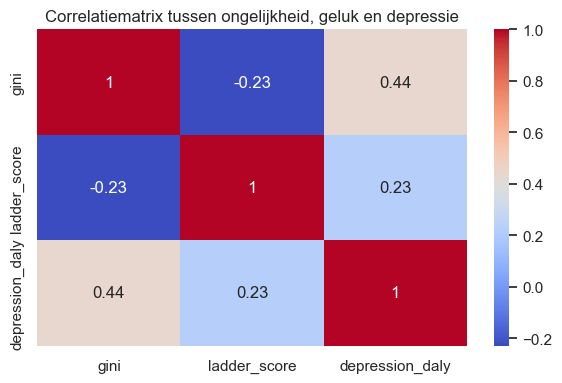

In [35]:
plt.figure(figsize=(6, 4))
sns.heatmap(mean_df[['gini', 'ladder_score', 'depression_daly']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlatiematrix tussen ongelijkheid, geluk en depressie")
plt.tight_layout()
plt.show()